# Exploring Bike Accident Data for Berlin

first visualization and exploration of destatis accident data, filtering for bicycle accidents 

## About the Data Set
* source: [Destatis Unfallatlas](https://unfallatlas.statistikportal.de/)
* [Licence](http://www.govdata.de/dl-de/by-2-0)
* for timespan of 2016-2024

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
csv_dir = Path("data/csv")
csv_files = sorted(csv_dir.glob("*.csv"))

if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {csv_dir.resolve()}")

dfs = []
for fp in csv_files:
    df = pd.read_csv(fp, low_memory=False, delimiter=";")
    df["source_file"] = fp.name 
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
print(f"Loaded {len(csv_files)} files -> combined shape: {df_all.shape}")

#print all column names
print("Columns:", df_all.columns.tolist())

df_all.head()

Loaded 9 files -> combined shape: (2098019, 35)
Columns: ['OBJECTID', 'UIDENTSTLA', 'ULAND', 'UREGBEZ', 'UKREIS', 'UGEMEINDE', 'UJAHR', 'UMONAT', 'USTUNDE', 'UWOCHENTAG', 'UKATEGORIE', 'UART', 'UTYP1', 'IstRad', 'IstPKW', 'IstFuss', 'IstKrad', 'IstSonstig', 'LICHT', 'STRZUSTAND', 'LINREFX', 'LINREFY', 'XGCSWGS84', 'YGCSWGS84', 'source_file', 'OBJECTID_1', 'ULICHTVERH', 'IstGkfz', 'IstSonstige', 'UIDENTSTLAE', 'IstStrassenzustand', 'OID_', 'PLST', 'FID', 'IstStrasse']


,OBJECTID,UIDENTSTLA,ULAND,UREGBEZ,UKREIS,UGEMEINDE,UJAHR,UMONAT,USTUNDE,UWOCHENTAG,...,OBJECTID_1,ULICHTVERH,IstGkfz,IstSonstige,UIDENTSTLAE,IstStrassenzustand,OID_,PLST,FID,IstStrasse
0,1.0,01170113152013852017,1,0,55,12,2017,1,5,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,01170113171013912017,1,0,60,53,2017,1,6,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,01170106105132242017,1,0,61,11,2017,1,18,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,01170114152013542018,1,0,55,42,2017,1,12,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,01170106161013732017,1,0,62,60,2017,1,8,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# drop all accidents that did not involve bicycles (column 'IstRad' != 1)
df_bike = df_all[df_all['IstRad'] == 1].copy()
print(f"Filtered to bicycle accidents -> shape: {df_bike.shape}")

# only keep accidents in Berlin (column 'ULAND' == 11)
df_bike_berlin = df_bike[df_bike['ULAND'] == 11].copy()
print(f"Filtered to bicycle accidents in Berlin -> shape: {df_bike_berlin.shape}")
df_bike_berlin.head()

Filtered to bicycle accidents -> shape: (626844, 35)
Filtered to bicycle accidents in Berlin -> shape: (33181, 35)


,OBJECTID,UIDENTSTLA,ULAND,UREGBEZ,UKREIS,UGEMEINDE,UJAHR,UMONAT,USTUNDE,UWOCHENTAG,...,OBJECTID_1,ULICHTVERH,IstGkfz,IstSonstige,UIDENTSTLAE,IstStrassenzustand,OID_,PLST,FID,IstStrasse
307975,NaN,NaN,11,0,3,3,2018,1,15,4,...,112747.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308120,NaN,NaN,11,0,3,3,2018,1,11,5,...,112892.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308130,NaN,NaN,11,0,2,2,2018,1,8,2,...,112902.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308149,NaN,NaN,11,0,1,1,2018,1,19,4,...,112921.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308175,NaN,NaN,11,0,9,9,2018,1,18,4,...,112947.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


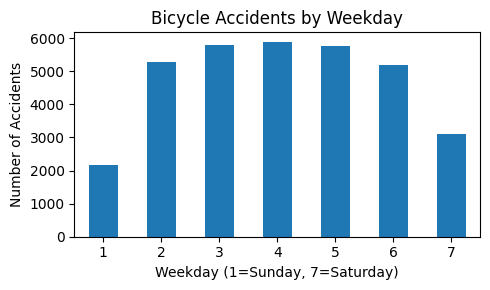

In [4]:
# plot number of accidents by weekday ('UWOCHENTAG')
weekday_counts = df_bike_berlin['UWOCHENTAG'].value_counts().sort_index()

plt.figure(figsize=(5, 3))
weekday_counts.plot(kind='bar')
plt.xlabel('Weekday (1=Sunday, 7=Saturday)')
plt.ylabel('Number of Accidents')
plt.title('Bicycle Accidents by Weekday')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

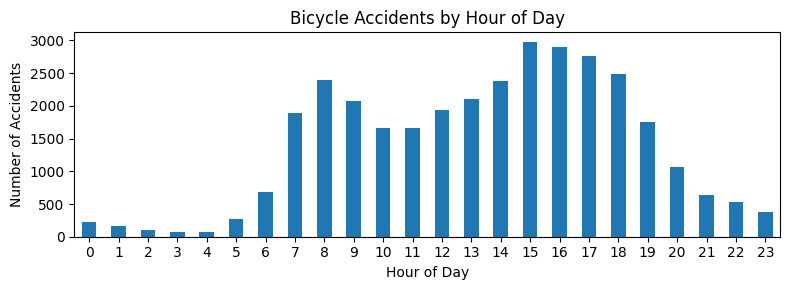

In [5]:
# plot number of accidents by hour of day ('USTUNDE')
hour_counts = df_bike_berlin['USTUNDE'].value_counts().sort_index()
plt.figure(figsize=(8, 3))
hour_counts.plot(kind='bar')    
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.title('Bicycle Accidents by Hour of Day')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

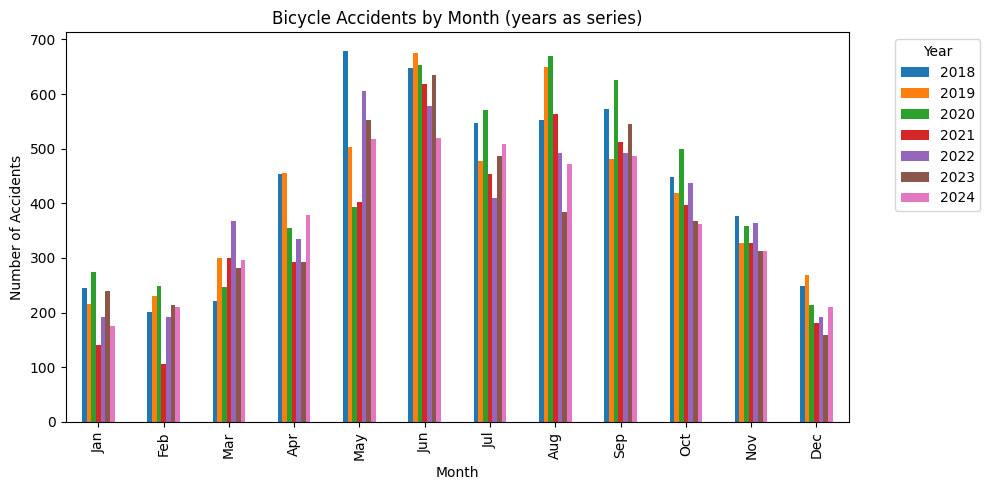

In [6]:
# plot months on the x-axis and years as series (switch year and month)
month_year_counts = df_bike_berlin.groupby(['UMONAT', 'UJAHR']).size().unstack(fill_value=0)
month_year_counts = month_year_counts.sort_index()

# replace numeric month index with short names for readability
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
month_year_counts.index = month_year_counts.index.map(lambda m: month_names[m-1] if 1 <= m <= 12 else str(m))

month_year_counts.plot(kind='bar', figsize=(10, 5))
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.title('Bicycle Accidents by Month (years as series)')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
  